# U-Net deconvolution of $C^\alpha$ images
v >= 12jan26

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
mpl.rcParams["font.size"] = 16
mpl.rcParams['axes.titlesize'] = 16
plt.rcParams['image.cmap'] = 'RdBu_r'

In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../code')) # path to your source code
sys.path.insert(0, module_path)

In [3]:
import torch
import json
from types import SimpleNamespace
#from model import *
from image_manip import *

In [4]:
import yaml

In [5]:
from model import *

In [6]:
from plot_utils import *

In [7]:
import pandas as pd

In [8]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

# Load Unets & Clean Calpha

In [13]:
import regex as re
import glob

file_pattern = re.compile(r".*?(\d+).*?")


def get_order(file):
    match = file_pattern.match(os.path.basename(file))
    if not match:
        return math.inf
    return int(match.groups()[-1])


def get_list(loc, pattern):
    # dir = pathlib.Path(dir)
    a = list(glob.glob(loc + "/" + pattern))
    return sorted(a, key=get_order)


def load_Unet_valdata(root_dir_infos,config_infos, alpha,device,ndata=200):
    root_dir = root_dir_infos[0] + str(alpha)+ root_dir_infos[1] + "/"
    if len(config_infos)==1:
        config_fn= root_dir + config_infos[0]+str(alpha)+".yaml"
    else:
        config_fn= root_dir + config_infos[0]+str(alpha)+ config_infos[1]+".yaml"

    ## Load yaml configuration file
    with open(config_fn, 'r') as config:
        settings_dict = yaml.safe_load(config)
    args = SimpleNamespace(**settings_dict)
    #  model
    model = UNet(args)
    model.to(device)
    # load trained parameters
    checkpoint = torch.load(root_dir+"Unet-Full_best_state.pth")
    model.load_state_dict(checkpoint["model_state_dict"])
    # evaluaton mode
    model.eval()

    # dataset "clean" Calpha images
    input_dir = args.input_root_dir + args.input_dataset
    
    print("dataset:",input_dir)
    data_clean = get_list(input_dir, "d*.npz")
    n_val = min(args.n_val,ndata)  # not used in the training
    data_val = data_clean[-n_val:]
    return model, data_val

In [14]:
unets = {}
datas = {}
alphas =  [1,2,3,4,5]

In [15]:
root_dir_infos = ["../Unet_Ca_","_onfly_b250_MSE_64kernels_4blocks_norm_m11"]
config_infos = ["config_UnetFull_100k_Ca_"]

for alpha in alphas:
    unets[alpha],datas[alpha] = load_Unet_valdata(root_dir_infos,
                                                  config_infos,
                                                  alpha,device=device,ndata=1000)

dataset: /lustre/fsn1/projects/rech/ixh/ufd72rp//dataset_ca_1/
dataset: /lustre/fsn1/projects/rech/ixh/ufd72rp//dataset_ca_2/
dataset: /lustre/fsn1/projects/rech/ixh/ufd72rp//dataset_ca_3/
dataset: /lustre/fsn1/projects/rech/ixh/ufd72rp//dataset_ca_4/
dataset: /lustre/fsn1/projects/rech/ixh/ufd72rp//dataset_ca_5/


In [16]:
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm import tqdm

In [17]:
def psnr(x,ref, max_I=1.0):
    mse = ((x-ref)**2).mean()
    return 10*(np.log10(max_I**2) - np.log10(mse))

In [18]:
class CustumDataset(Dataset):
    """Load the data set which is supposed to be a Numpy structured array"""

    def __init__(self, dataset, quiet=True):
        """
        dataset: list of files
        """
        self.datas = dataset
        if not quiet:
            print(
                f"CustumDataset: {len(self.datas)} data loaded",
            )

    def __len__(self):
        return len(self.datas)

    def __getitem__(self, index):
        """
        transform clean image into conv + noisy image
        transform from numpy HW  to torch CWH (C=1)
        """
        img_clean = np.load(self.datas[index])["img"]
        # rescale pixel value in range
        img_clean = rescale_image_range(img_clean, max_I=1.0, min_I=-1.0)

        # float32 array
        img_clean = np.float32(img_clean)

        # torch convention CHW
        img_clean = np.expand_dims(img_clean, axis=0)  # 1xHxW

        # to torch tensor
        clean = torch.from_numpy(img_clean)

        return clean

def batch_ave_psnr_torch(ref_ims, images ,max_I=1.0):
    '''
    batch of ref_im and im are tensors of dims N,C, W, H
    returns ave psnr of a batch of images 
    '''
    mse = ((ref_ims - images)**2).mean(dim=(1,2,3))
    psnr_all =  10*(np.log10(max_I**2) - torch.log10(mse))
    return psnr_all.mean()

def calc_psnr(model,loader,fwhm_range,sigma_range,device):
    psnr_in_all  = np.zeros((len(fwhm_range),len(sigma_range)))
    psnr_out_all = np.zeros((len(fwhm_range),len(sigma_range)))
    for ifwhm,psf_fwhm in enumerate(fwhm_range):
        for isig,sigma_noise in enumerate(sigma_range):
            #print(f"fwhm {psf_fwhm:.2f}, sigma {sigma_noise:.2f}")
            psnr_in  = 0
            psnr_out = 0
            for i, imgs_clean in enumerate(loader,0):
                model = model.eval()
                imgs_clean = imgs_clean.to(device)
                #print("imgs_clean shape",imgs_clean.shape)
                # convolution
                psf = make_psf(fwhm=psf_fwhm)
                psf = (
                    torch.from_numpy(psf[None, None, :, :])
                    .to(torch.float32)
                    .to(device)
                )
                imgs_conv = F.conv2d(imgs_clean, psf, padding="same")
                # add noise
                noise = sigma_noise * torch.randn(size=imgs_conv.shape, device=device)
                imgs  = imgs_conv + noise
                with torch.no_grad():
                    output = model(imgs)
                # psnr for this batch
                psnr_in  += batch_ave_psnr_torch(imgs_clean,imgs)
                psnr_out += batch_ave_psnr_torch(imgs_clean,output)
            # psnr averaged on all batch
            #print("i after loop:",i)
            psnr_in_all[ifwhm,isig]  = psnr_in/(i+1)
            psnr_out_all[ifwhm,isig] = psnr_out/(i+1)
    #end
    return psnr_in_all, psnr_out_all

# Example of $C^\alpha$ images

In [19]:
set_seed(12345)

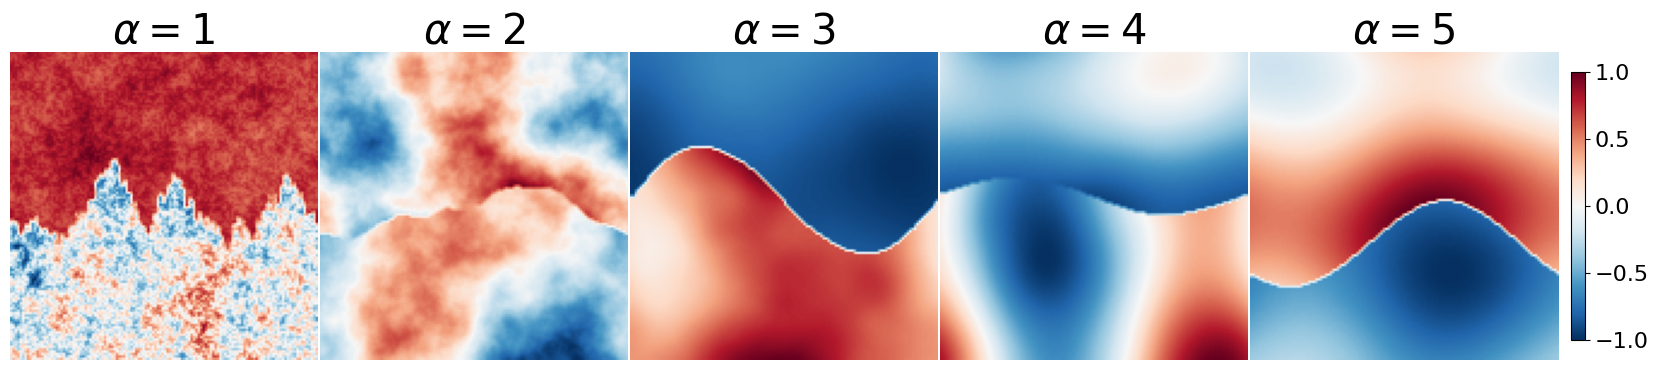

In [20]:
fig,axs=plt.subplots(1,5,figsize=(5*4,4))
for i,alpha in enumerate(alphas):
    loader = DataLoader(dataset=CustumDataset(datas[alpha]), batch_size=1, shuffle=True);
    img = next(iter(loader))
    im=axs[i].imshow(img.cpu().squeeze(),vmin=-1, vmax=1)
    axs[i].axis('off');
    axs[i].set_title(fr"$\alpha=${alpha}",fontsize=30)
cax = fig.add_axes([axs[-1].get_position().x1+6e-3, 
                    axs[-1].get_position().y0, 7e-3, 
                    axs[-1].get_position().height])
plt.colorbar(im,cax=cax);

plt.subplots_adjust(wspace=0, hspace=0)
#fig.savefig("calpha_examples.pdf",bbox_inches='tight', pad_inches=0)

# U-Net trained for blind deconvolution but tested in denoising task

In [21]:
def psnr2sig(psnr):
    return 10**(-psnr/20)

In [22]:
def calc_psnr_v2(rng,n_epoch,model,loader,fwhm_range,psnr_range,device):
    fwhm_min, fwhm_max = fwhm_range
    psnr_min, psnr_max = psnr_range
    sigma_min, sigma_max = psnr2sig(psnr_max), psnr2sig(psnr_min)
    psnr_in_all  = []
    psnr_out_all = []
    model = model.eval()
    for epoch in tqdm(range(n_epoch)):
        for i, imgs_clean in enumerate(loader):
            imgs_clean = imgs_clean.to(device)
            #convolution
            psf_fwhm = rng.uniform(low=fwhm_min, high=fwhm_max)
            psf = make_psf(fwhm=psf_fwhm)
            imgs_conv = F.conv2d(imgs_clean, 
                             torch.from_numpy(psf[None, None, :, :])
                                 .to(torch.float32)
                                 .to(device), 
                             padding="same")
            # add noise
            #sigma_noise = torch.rand(size=(imgs_conv.shape[0], 1, 1, 1), device=device)
            #sigma_noise = sigma_noise * (sigma_max - sigma_min) + sigma_min
            psnr_noise = torch.rand(size=(imgs_conv.shape[0], 1, 1, 1), device=device)
            psnr_noise = psnr_noise * (psnr_max - psnr_min) + psnr_min
            sigma_noise = psnr2sig(psnr_noise)
            noise = sigma_noise * torch.randn(size=imgs_conv.shape, device=device)
            imgs  = imgs_conv + noise
            with torch.no_grad():
                output = model(imgs)
            # psnr
            psnr_in  = batch_ave_psnr_torch(imgs_clean,imgs)
            psnr_out = batch_ave_psnr_torch(imgs_clean,output)
            #if psnr_in>23:
            #    print("...",psf_fwhm,sigma_noise.item(),psnr_in.item(),psnr_out.item())
            psnr_in_all.append(psnr_in.cpu())
            psnr_out_all.append(psnr_out.cpu())
    #end
    return np.array(psnr_in_all), np.array(psnr_out_all)

In [23]:
fwhm_range = (0,0) # no blurring applyied 
psnr_range = (0,30)
sigma_range = (psnr2sig(psnr_range[1]),psnr2sig(psnr_range[0]))

In [24]:
bin_centers={}
means={}
standard_deviations={}
err_means={}
for alpha in alphas:
    seed = 42
    set_seed(seed)
    rng = np.random.default_rng(seed)
    loader = DataLoader(dataset=CustumDataset(datas[alpha]), batch_size=1, shuffle=False)
    psnr_in_rdm,psnr_out_rdm = calc_psnr_v2(rng,10,unets[alpha],loader,fwhm_range,psnr_range,device)
    bin_centers[alpha], means[alpha], _ , err_means[alpha] = profile_stat(psnr_in_rdm,psnr_out_rdm, bins=15)

100%|██████████| 10/10 [01:29<00:00,  8.93s/it]


In [25]:
df1 = pd.DataFrame(bin_centers)
df2 = pd.DataFrame(means)
df3 = pd.DataFrame(err_means)

In [26]:
alphas = list(df1.columns.values)

In [27]:
couleurs_temperature = [
    "#0000FF",  # Bleu (froid)
    "#9D00FF",  # Violet
    "#00AA00",  # Vert
    "#FF8C00",  # Orange
    "#FF0000"   # Rouge (chaud)
]

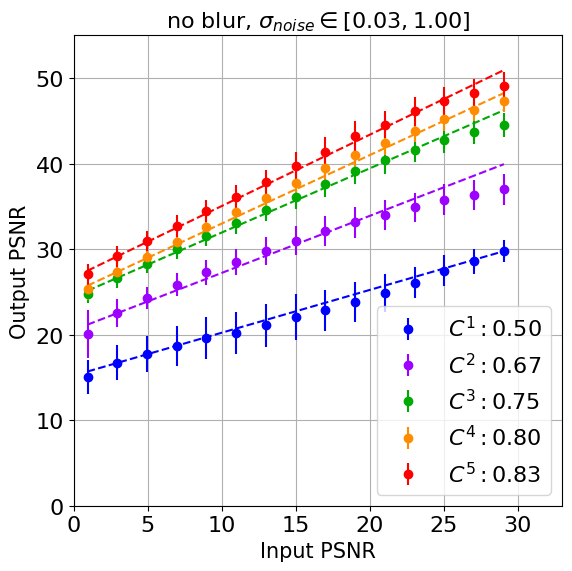

In [28]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
for i,alpha in enumerate(alphas):
    ax.errorbar(x=df1[alpha], y=df2[alpha], yerr=df3[alpha], linestyle='none', marker='o',
                 label=fr"$C^{alpha}:{(alpha/(1+alpha)):.2f}$",
               mfc=couleurs_temperature[i],
               mec=couleurs_temperature[i],
               ecolor=couleurs_temperature[i])
    ax.plot(df1[alpha],
            (df1[alpha]-df1[alpha][1])*(alpha/(1+alpha))+df2[alpha][1],ls="--",
            color=couleurs_temperature[i])

ax=plt.gca()
ax.set_xlim([0,33])
ax.set_ylim([0,55]);
ax.set_xlabel('Input PSNR', fontsize = 15)
ax.set_ylabel('Output PSNR', fontsize = 15);
ax.set_title(rf"no blur, $\sigma_{{noise}} \in [{sigma_range[0]:.2f},{sigma_range[1]:.2f}]$")
ax.legend();
ax.grid();
plt.tight_layout()
#fig.savefig("calpha_psnr_unet_vs_psnr_obs_noblur.pdf")

## Jacobian analysis

In [29]:
from linear_approx import calc_jacobian, traj_projections

In [30]:
alpha=5  # chooose a regularity

In [31]:
loader = DataLoader(dataset=CustumDataset(datas[alpha]), batch_size=1, shuffle=False)

In [32]:
model = unets[alpha]
model.eval()
imgs_clean = next(iter(loader))
imgs_clean = imgs_clean.to(device)
psf = make_psf(fwhm=0.)
imgs_conv = F.conv2d(imgs_clean, 
                    torch.from_numpy(psf[None, None, :, :])
                                 .to(torch.float32)
                                 .to(device), 
                             padding="same")
noise = 0.5 * torch.randn(size=imgs_conv.shape, device=device)
noisy  = imgs_conv + noise
with torch.no_grad():
    denoised = model(noisy).detach()


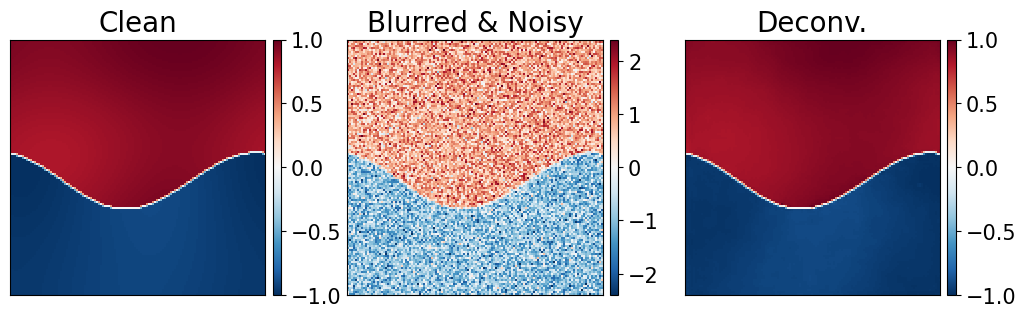

In [33]:
fig,axs=plt.subplots(1,3,figsize=(3*4,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.32, hspace=None)


im=axs[0].imshow(imgs_clean.squeeze().cpu(), cmap='RdBu_r', vmin=-1,vmax=1)
cax = fig.add_axes([axs[0].get_position().x1+6e-3, 
                    axs[0].get_position().y0, 7e-3, 
                    axs[0].get_position().height])
axs[0].set_title("Clean",fontsize=20)
cbar=plt.colorbar(im,cax=cax);
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(15)

im=axs[1].imshow(noisy.detach().squeeze().cpu(),cmap='RdBu_r',vmin=-2.4,vmax=2.4) 
cax = fig.add_axes([axs[1].get_position().x1+6e-3, 
                    axs[1].get_position().y0, 7e-3, 
                    axs[1].get_position().height])
axs[1].set_title("Blurred & Noisy",fontsize=20)
cbar=plt.colorbar(im,cax=cax);
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(15)

im=axs[2].imshow(denoised.detach().squeeze().cpu(),cmap='RdBu_r', vmin=-1,vmax=1)
cax = fig.add_axes([axs[2].get_position().x1+6e-3, 
                    axs[2].get_position().y0, 7e-3, 
                    axs[2].get_position().height])
axs[2].set_title("Deconv.",fontsize=20)
cbar=plt.colorbar(im,cax=cax);
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(15)

axs=axs.ravel()
for ax in axs:
    ax.set(xticks=[], yticks=[])

In [35]:
K = imgs_clean.shape[-1]
J = calc_jacobian(noisy, unets[alpha])
##I = torch.eye(K**2).to(device) ### in case residual Unet
#U,S, V = torch.svd(I - J)  ### in case residual Unet
U,S,V = torch.svd(J) 

In [38]:
(1+alpha)/2

3.0

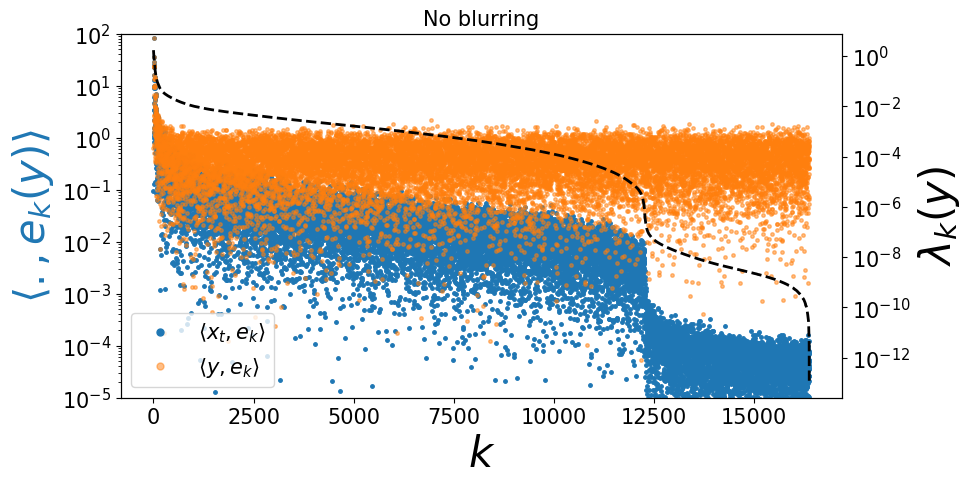

In [41]:
# <y, e_k(y)>
cors_y = []
for j in range(K*K): 
    cors_y.append( torch.dot(U[:,j], noisy.flatten() ).cpu() )
cors_y = torch.stack(cors_y)  

#<x, e_k(y)>
cors = []
for j in range(K*K): 
    cors.append( torch.dot(U[:,j], imgs_clean.flatten() ).cpu() )
cors = torch.stack(cors)  



fig, ax1 = plt.subplots(1,1, figsize = (10,5), sharey=False )

color = 'tab:blue'
ax1.set_xlabel(r'$k$', fontsize=30)
ax1.plot(abs(cors.cpu()), '.', markersize=5 , label = r'$ \langle x_t,e_k\rangle $', alpha = 1)
ax1.plot(abs(cors_y.detach().cpu()),'.',markersize=5 , label = r'$ \langle y,e_k\rangle $', alpha = 0.5)

ax1.set_ylabel(r'$\langle .,e_k(y)\rangle $', color=color,fontsize = 30)
ax1.legend(loc='lower left', fontsize=15, markerscale=2)

plt.xticks( fontsize = 15)
plt.yticks( fontsize = 15);
ax1.set_yscale("log")
ax1.set_ylim([1e-5,1e2])

color = 'tab:red'
ax2 = ax1.twinx()  
ax2.set_ylabel(r'$\lambda_k(y)$', color='k', fontsize = 30, rotation=90)
ax2.plot(S.cpu(), lw=2,ls="--", alpha = 1, color='k');
ax2.set_yscale("log")
plt.yticks( fontsize = 15);

plt.tight_layout()
plt.title("No blurring",fontsize=15);

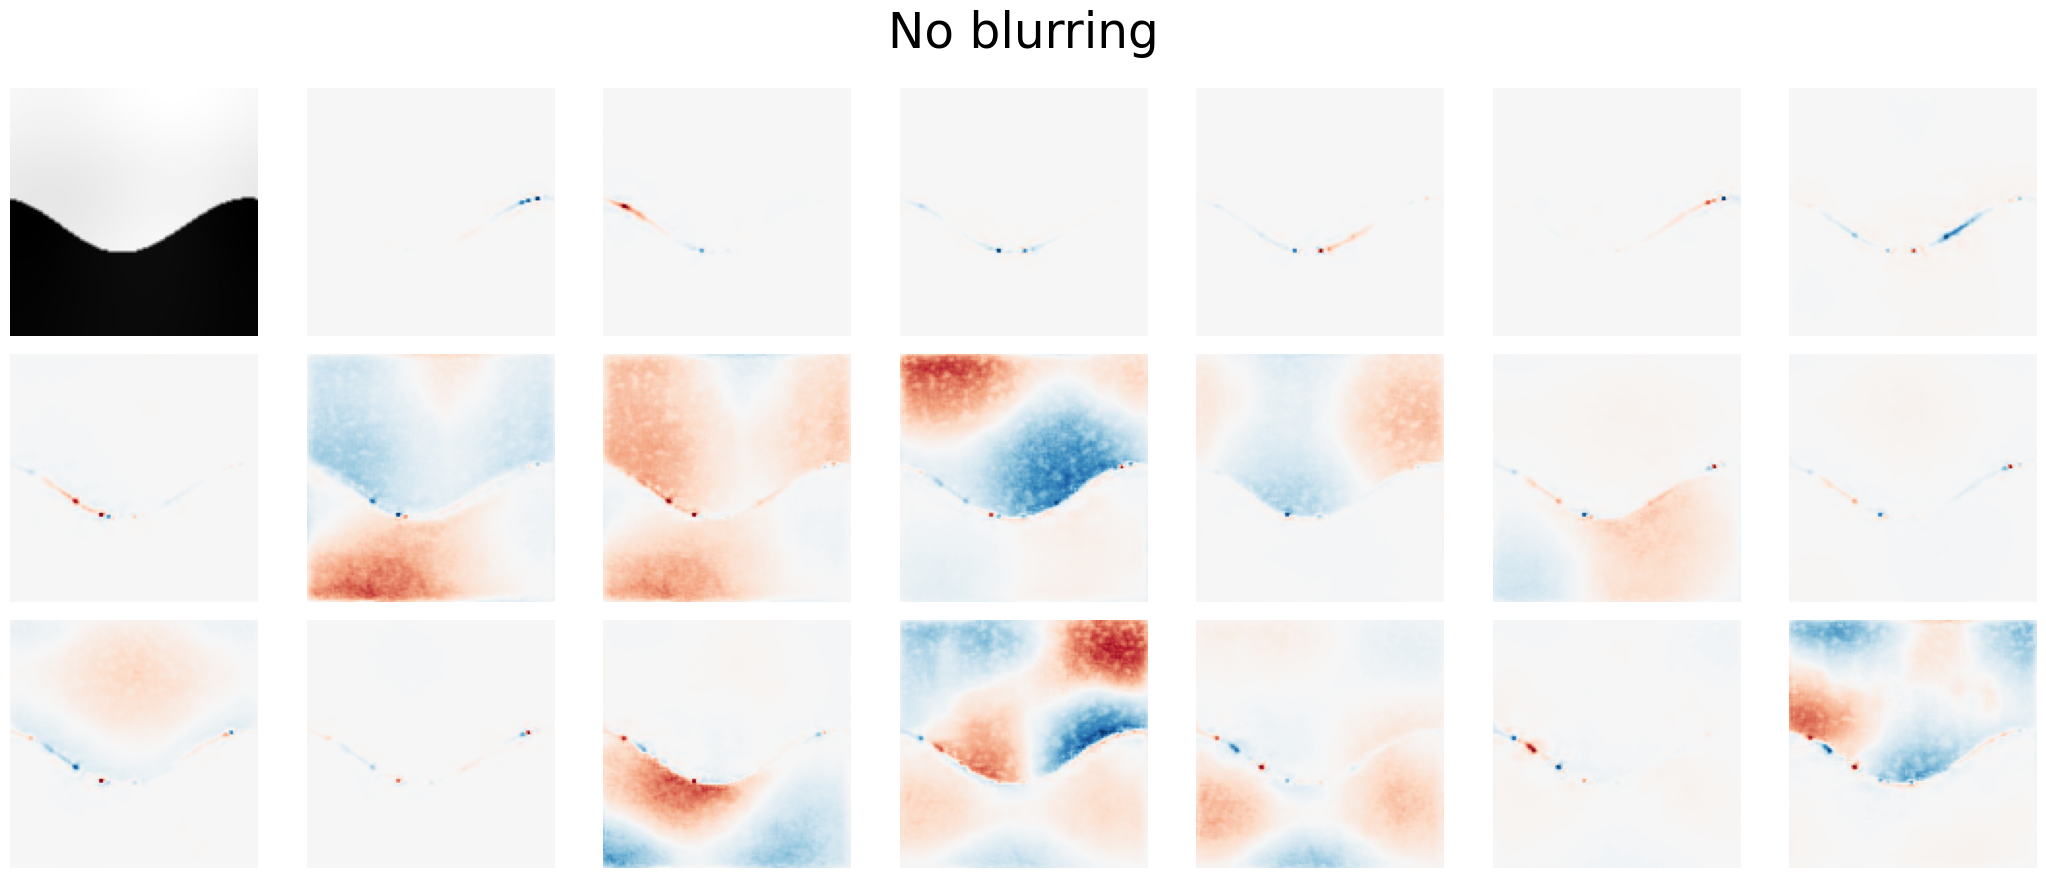

In [42]:
import matplotlib.colors as colors
k = 20
skips = 1
shift = 0
ids = np.concatenate([range(shift,k*skips+shift, skips) ])

fig, axs = plt.subplots(3,7, figsize = (7*3,3*3))
axs = axs.ravel()

axs[0].imshow(imgs_clean.cpu().squeeze(), 'gray')

for i in range(k): 
    j = ids[i]
#    v_lim = max(abs(V[:,j].min()), abs(V[:,j].max())).item()/2
    axs[i+1].imshow(V[:,j].reshape(noisy.shape[2], noisy.shape[3]).cpu(), 'RdBu',norm=colors.CenteredNorm()) 
for i in range(len(axs)): 
    axs[i].axis('off');

fig.suptitle("No blurring",fontsize=35)
plt.tight_layout();

# Same clean image but with blurring

In [43]:
psf = make_psf(fwhm=10.)
imgs_conv = F.conv2d(imgs_clean, 
                    torch.from_numpy(psf[None, None, :, :])
                                 .to(torch.float32)
                                 .to(device), 
                             padding="same")
noise = 0.5 * torch.randn(size=imgs_conv.shape, device=device)
noisy  = imgs_conv + noise
with torch.no_grad():
    denoised = model(noisy).detach()


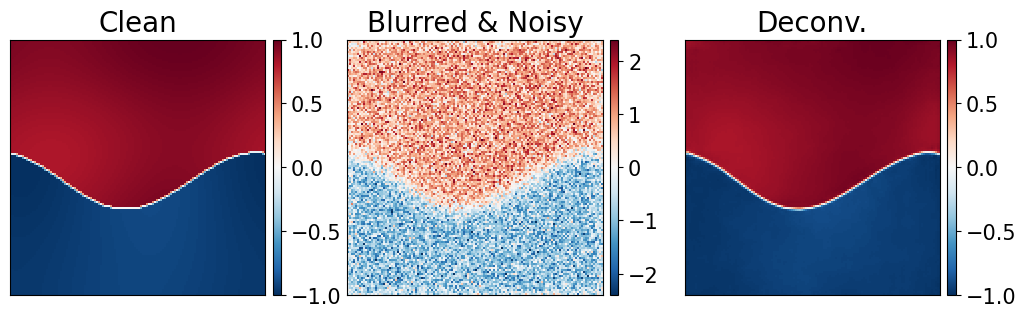

In [44]:
fig,axs=plt.subplots(1,3,figsize=(3*4,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.32, hspace=None)


im=axs[0].imshow(imgs_clean.squeeze().cpu(), cmap='RdBu_r', vmin=-1,vmax=1)
cax = fig.add_axes([axs[0].get_position().x1+6e-3, 
                    axs[0].get_position().y0, 7e-3, 
                    axs[0].get_position().height])
axs[0].set_title("Clean",fontsize=20)
cbar=plt.colorbar(im,cax=cax);
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(15)

im=axs[1].imshow(noisy.detach().squeeze().cpu(),cmap='RdBu_r',vmin=-2.4,vmax=2.4) 
cax = fig.add_axes([axs[1].get_position().x1+6e-3, 
                    axs[1].get_position().y0, 7e-3, 
                    axs[1].get_position().height])
axs[1].set_title("Blurred & Noisy",fontsize=20)
cbar=plt.colorbar(im,cax=cax);
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(15)

im=axs[2].imshow(denoised.detach().squeeze().cpu(),cmap='RdBu_r', vmin=-1,vmax=1)
cax = fig.add_axes([axs[2].get_position().x1+6e-3, 
                    axs[2].get_position().y0, 7e-3, 
                    axs[2].get_position().height])
axs[2].set_title("Deconv.",fontsize=20)
cbar=plt.colorbar(im,cax=cax);
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(15)

axs=axs.ravel()
for ax in axs:
    ax.set(xticks=[], yticks=[])



#fig.savefig("calpha_blur_noisy_deconv_imgs.pdf",bbox_inches='tight', pad_inches=0)

In [45]:
K = imgs_clean.shape[-1]
J = calc_jacobian(noisy, unets[alpha])
##I = torch.eye(K**2).to(device) ### in case residual Unet
#U,S, V = torch.svd(I - J)  ### in case residual Unet
U_blur,S_blur,V_blur = torch.svd(J) 

128


Text(0.5, 1.0, 'With blurring fwhm=10')

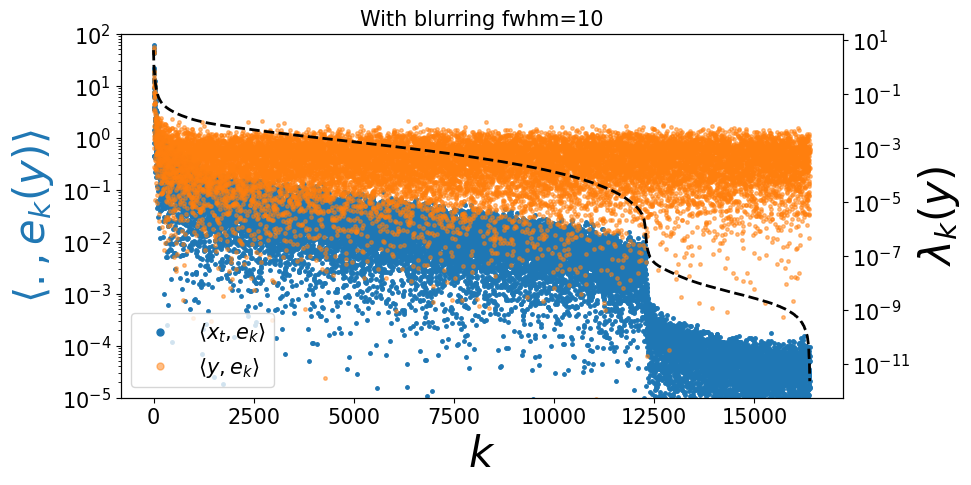

In [46]:
# <y, e_k(y)>
cors_y = []
for j in range(K*K): 
    cors_y.append( torch.dot(U_blur[:,j], noisy.flatten() ).cpu() )
cors_y = torch.stack(cors_y)  

#<x, e_k(y)>
cors = []
for j in range(K*K): 
    cors.append( torch.dot(U_blur[:,j], imgs_clean.flatten() ).cpu() )
cors = torch.stack(cors)  



fig, ax1 = plt.subplots(1,1, figsize = (10,5), sharey=False )

color = 'tab:blue'
ax1.set_xlabel(r'$k$', fontsize=30)
ax1.plot(abs(cors.cpu()), '.', markersize=5 , label = r'$ \langle x_t,e_k\rangle $', alpha = 1)
ax1.plot(abs(cors_y.detach().cpu()),'.',markersize=5 , label = r'$ \langle y,e_k\rangle $', alpha = 0.5)
ax1.set_ylabel(r'$\langle .,e_k(y)\rangle $', color=color,fontsize = 30)
ax1.legend(loc='lower left', fontsize=15, markerscale=2)

plt.xticks( fontsize = 15)
plt.yticks( fontsize = 15);
ax1.set_yscale("log")
ax1.set_ylim([1e-5,1e2])

color = 'tab:red'
ax2 = ax1.twinx()  
ax2.set_ylabel(r'$\lambda_k(y)$', color='k', fontsize = 30, rotation=90)
ax2.plot(S_blur.cpu(), lw=2,ls="--", alpha = 1, color='k');
ax2.set_yscale("log")
plt.yticks( fontsize = 15);

plt.tight_layout()
plt.title("With blurring fwhm=10",fontsize=15)
#fig.savefig("calpha_sparse_fwhm10.pdf")

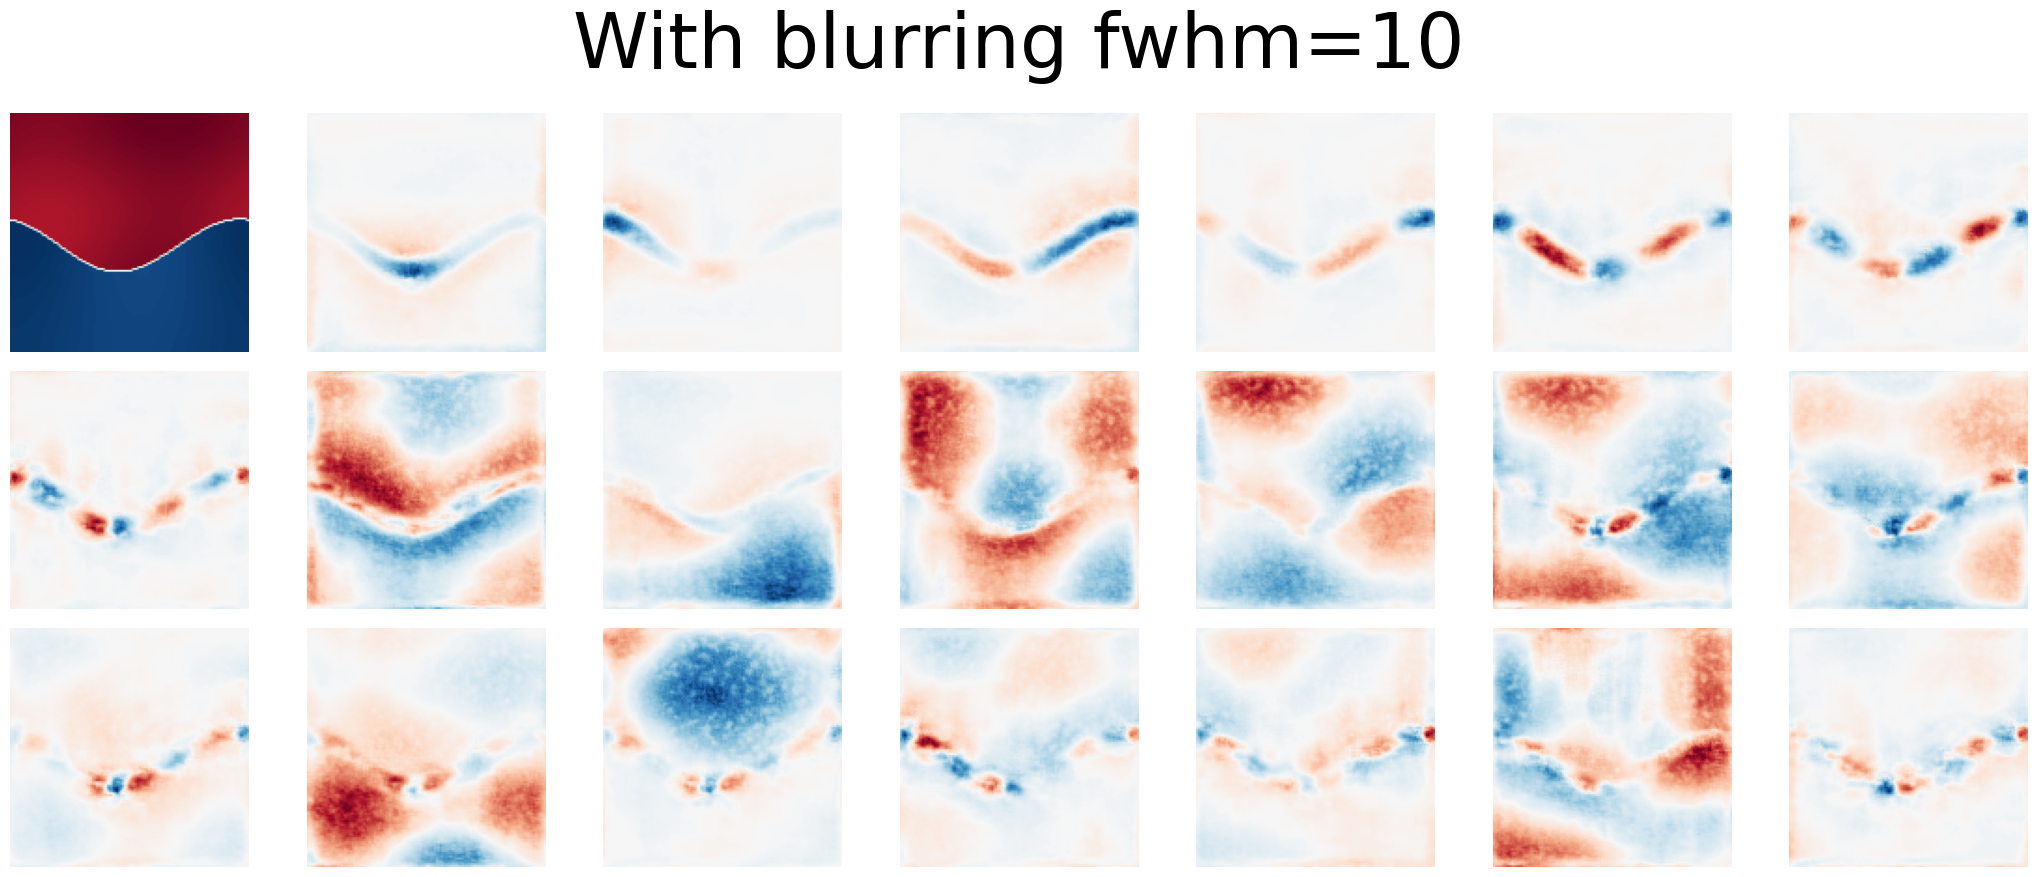

In [47]:
import matplotlib.colors as colors
k = 20
skips = 1
shift = 0
ids = np.concatenate([range(shift,k*skips+shift, skips) ])

fig, axs = plt.subplots(3,7, figsize = (7*3,3*3))
axs = axs.ravel()

axs[0].imshow(imgs_clean.cpu().squeeze(),vmin=-1,vmax=1)

for i in range(k): 
    j = ids[i]
    #v_lim = max(abs(V[:,j].min()), abs(V[:,j].max())).item()/2
    axs[i+1].imshow(V_blur[:,j].reshape(noisy.shape[2], noisy.shape[3]).cpu(), 
                    'RdBu',norm=colors.CenteredNorm()) 
for i in range(len(axs)): 
    axs[i].axis('off');

fig.suptitle("With blurring fwhm=10",fontsize=55)
plt.tight_layout()
#fig.savefig("calpha_Vecprop_fwhm10.pdf")
